In [ ]:
import urllib.request
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
import gdown
import zipfile
import os

file_id = '1MpetjUWePA1gcOT2OBV5m1O0o8A-u8yY'

# Download the file using gdown
download_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'downloaded_file.zip'
gdown.download(download_url, output_file, quiet=False)

# Unzipping the downloaded file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

# Optionally, remove the zip file after extraction
os.remove(output_file)

print("File downloaded and extracted successfully.")

Downloading...
From (original): https://drive.google.com/uc?id=1MpetjUWePA1gcOT2OBV5m1O0o8A-u8yY
From (redirected): https://drive.google.com/uc?id=1MpetjUWePA1gcOT2OBV5m1O0o8A-u8yY&confirm=t&uuid=27e77666-5646-446d-969b-08b255932421
To: /content/downloaded_file.zip
100%|██████████| 1.23G/1.23G [00:13<00:00, 90.3MB/s]


File downloaded and extracted successfully.


In [ ]:
train_path = "/content/extracted_files/chest_xray/train"
val_path = "/content/extracted_files/chest_xray/valid"
test_path = "/content/extracted_files/chest_xray/test"

# ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
# Load VGG16 model without top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = Flatten()(vgg16_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=vgg16_base.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20,  # You can start with this
    callbacks=[early_stopping]  # Early stopping callback
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 649ms/step - accuracy: 0.7670 - loss: 0.5013 - val_accuracy: 0.8092 - val_loss: 0.4040
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.3041
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 642ms/step - accuracy: 0.8899 - loss: 0.2673 - val_accuracy: 0.8421 - val_loss: 0.3530
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1357
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 629ms/step - accuracy: 0.9088 - loss: 0.2304 - val_accuracy: 0.8569 - val_loss: 0.3412
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3588
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 627ms/step - accuracy: 0.9223 - loss: 0.2029 - val_accuracy: 0.8618 - val_loss: 0.3308


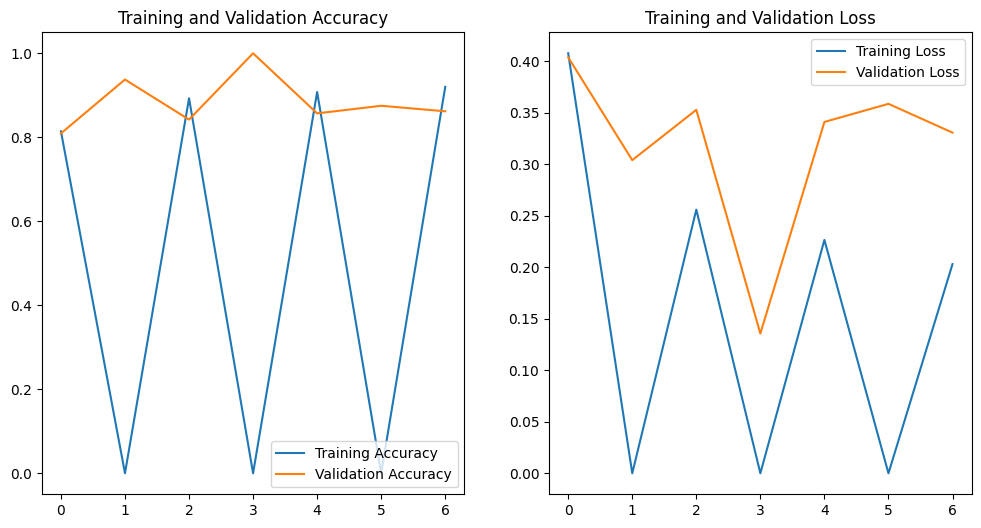

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and validation accuracy from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Plot the accuracy and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7500 - loss: 0.4910
Test Accuracy: 0.75


In [ ]:
# Save the trained model
model.save('model.h5')

{0: 'NORMAL', 1: 'PNEUMONIA'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


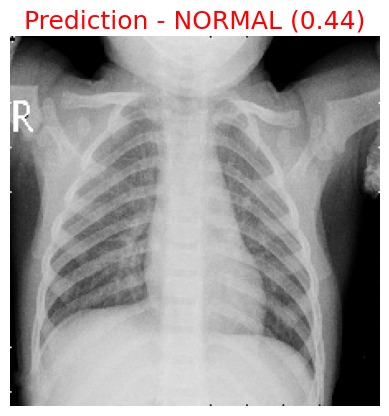

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

cls_dict={v:k for k,v in train_generator.class_indices.items()}
print(cls_dict)

def predict_image(filename, model):
    # Load and preprocess the image
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0

    # Make a prediction
    prediction = model.predict(img_processed)

    # Assuming binary classification, prediction will be a probability
    prob = prediction[0][0]
    class_idx = int(prob > 0.5)
    class_label = cls_dict[class_idx]

    # Display the image and prediction
    plt.title(f"Prediction - {class_label} ({prob:.2f})", size=18, color='red')
    plt.imshow(img_array)
    plt.axis('off')  # Hide the axis
    plt.show()

predict_image(r"/content/extracted_files/chest_xray/test/NORMAL/NORMAL2-IM-1430-0001.jpeg", model)